# High level view of the workflow
* Get data ready (turn into tensors)
* Build or pick a pretrained model which suits our problem
    * Pick a loss function & optimizer
    * Build a training loop
* Fit the model to the data and make a prediction
* Evaluate the model
* Improve through experimentation
* Save and reload the trained model

Resources:
* https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb

In [243]:
import torch
from torch import nn # all of PyTorch's neural network modules
import matplotlib.pyplot as plt

torch.__version__, torch.cuda.is_available()

('2.9.1+cu130', True)

## 1. Data preparing and loading

Can come in any form:
* Spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

In [244]:
# Create some known data using linear regression

# Known parameters
weight = 0.7
bias = 0.3

# Create features and labels
start = 0
end = 1
step = 0.02
X = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1) # features
y = weight * X + bias # labels

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [245]:
len(X), len(y)

(50, 50)

In [246]:
### Split data into training and test sets
train_split = int(0.8 * len(X)) # 80% of data for training
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualize the data

In [247]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions to ground truth labels.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Plot predictions if they exist
    if predictions is not None:
        # Plot predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

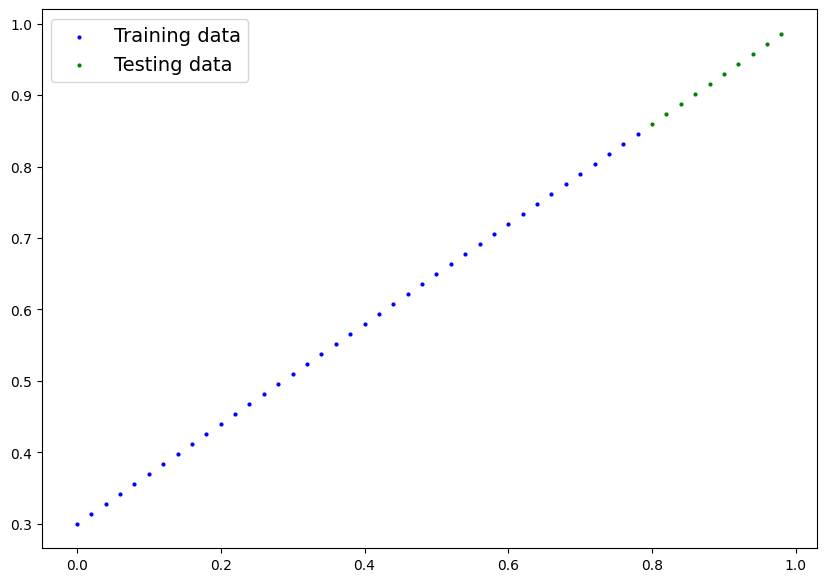

In [248]:
plot_predictions()

## 2. Build model

* Start with random values of weight and bias
* Look at training data and adjust the random values to get closer to the ideal values

The process:
1. Gradient descent
2. Backpropagation

In [249]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # almost every PyTorch model subclasses nn.Module, the base class for all neural network modules
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # start with random weights
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # start with random bias
        # Note: requires_grad=True means PyTorch will track gradients with respect to these parameters during backpropagation

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
        return self.weights * x + self.bias # linear regression formula

### PyTorch model building essentials

* torch.nn: all of the building blocks for computational graphs (which covers neural networks)
* torch.nn.Parameter: what parameters our model should try and learn, often a PyTorch layer from torch.nn sets these
* torch.nn.Module: base class for all NN models. If subclassed, overwrite `forward`
* torch.optim: where optimizers in PyTorch live; they help with gradient descent
* def forward(): all nn.Module subclasses are required to overwrite this. It defines what happens in forward computation
* torch.utils.data.Dataset: map between key (label) and sample (features) pairs of the data
* torch.utils.data.DataLoader: creates Python iterable over a torch Dataset

### Checking contents of PyTorch model

Create an instance of the class and check contents.

Check model parameters using `.parameters()`

In [250]:
# Create a manual seed
torch.manual_seed(42)

# Instantiate the model
model_0 = LinearRegressionModel()
model_0, model_0.weights, model_0.bias

(LinearRegressionModel(),
 Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True))

In [251]:
# List the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [252]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

Check how well it predicts `y_test` based on `x_test`

The model passes our data through the `forward` method

In [253]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [254]:
# Make prediction
with torch.inference_mode(): # inference mode is a context manager that disables gradient tracking
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [255]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

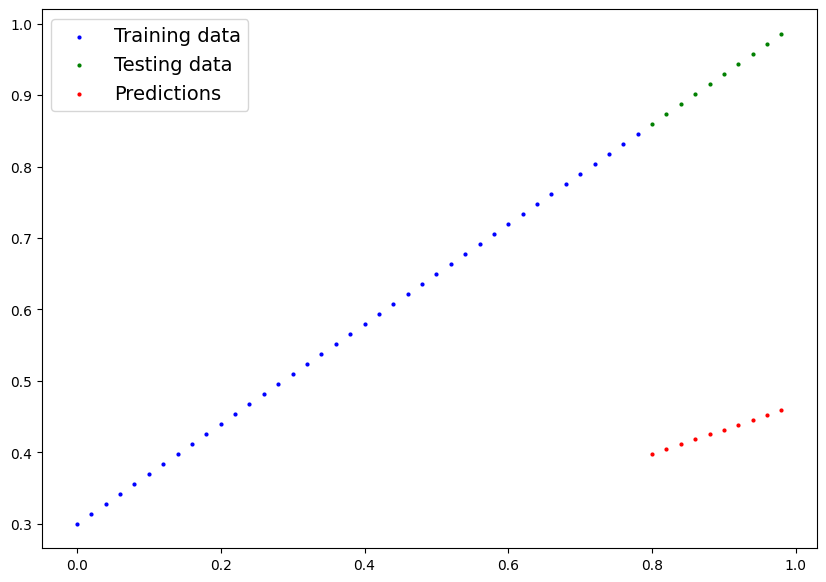

In [256]:
plot_predictions(predictions=y_preds)

## 3. Train the model

Move from some (unknown) parameters to known/expected parameters, or from a poor representation of the data to a better representation of the data

One way to measure the accuracy of the model is to use a **Loss function**.

**Optimizer** takes into account the loss of a model and adjusts the model's parameters (weights and biases) to reduce the loss.

For PyTorch, we need:
- A training loop
- A testing loop

In [257]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [258]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [259]:
# Set up a loss function
Loss_fn = nn.L1Loss() # Mean Absolute Error (MAE)

# Set up an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # Stochastic Gradient Descent (SGD)

### Building training loop and testing loop in PyTorch

What we need in training loop:

0. Loop through the data
1. Forward pass/propagation (data is taken through `forward` method)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - Use the optimizer to adjust our model's parameter to try and improve the loss (**gradient descent**)

In [260]:
# Init results for observation (store actual values as NumPy, not references)
results = []
metrics = {"train_loss": [], "test_loss": []}
params = list(model_0.parameters())
results.append((params[0].detach().numpy(), params[1].detach().numpy()))

In [261]:
# torch.manual_seed(42)

# 1 epoch is one loop through the data
epochs = 200

# 0. Loop through the data
for epoch in range(epochs):
    ### Training
    # Set the model to training mode
    model_0.train() # sets all parameters with require_grad=True to require gradients

    # 1. Forward pass
    y_pred = model_0.forward(X_train)

    # 2. Calculate the loss
    loss = Loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad, clear old gradients
    optimizer.zero_grad()

    # 4. Backpropagation on the loss wrt the parameters of the model, compute new gradients
    loss.backward()

    # 5. Step the optimizer (perform gradient descent), update parameters
    optimizer.step() # by default, how the optimizer changes will accumulate through the loop, so zero them at the start of the next iteration (step 3)

    # Save to results
    params = list(model_0.parameters())
    results.append((params[0].detach().numpy(), params[1].detach().numpy()))
    metrics["train_loss"].append(loss.detach().numpy())

    ### Testing
    model_0.eval() # turns off settings in the model not needed for evaluation/testing
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_0.forward(X_test)

        # 2. Calculate the test loss
        test_loss = Loss_fn(test_pred, y_test)
        metrics["test_loss"].append(test_loss.detach().numpy())

    if epoch % 50 == 0:
        print(f"Epoch: {epoch}\n  Loss: {loss}\n  Test loss: {test_loss}")
        print(f"  {model_0.state_dict()}")

Epoch: 0
  Loss: 0.31288138031959534
  Test loss: 0.48106518387794495
  OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 50
  Loss: 0.04167863354086876
  Test loss: 0.09919948130846024
  OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 100
  Loss: 0.024458957836031914
  Test loss: 0.05646304413676262
  OrderedDict({'weights': tensor([0.5800]), 'bias': tensor([0.3503])})
Epoch: 150
  Loss: 0.0072835334576666355
  Test loss: 0.016474086791276932
  OrderedDict({'weights': tensor([0.6654]), 'bias': tensor([0.3143])})


In [262]:
print("Results (weight, bias):")
for i, (w, b) in enumerate(results):
    if i % 50 == 0:
        print(f"Step {i}: weight={w.item():.4f}, bias={b.item():.4f}")

print(f"\nTarget: weight={weight}, bias={bias}")

Results (weight, bias):
Step 0: weight=0.6990, bias=0.3093
Step 50: weight=0.6990, bias=0.3093
Step 100: weight=0.6990, bias=0.3093
Step 150: weight=0.6990, bias=0.3093
Step 200: weight=0.6990, bias=0.3093

Target: weight=0.7, bias=0.3


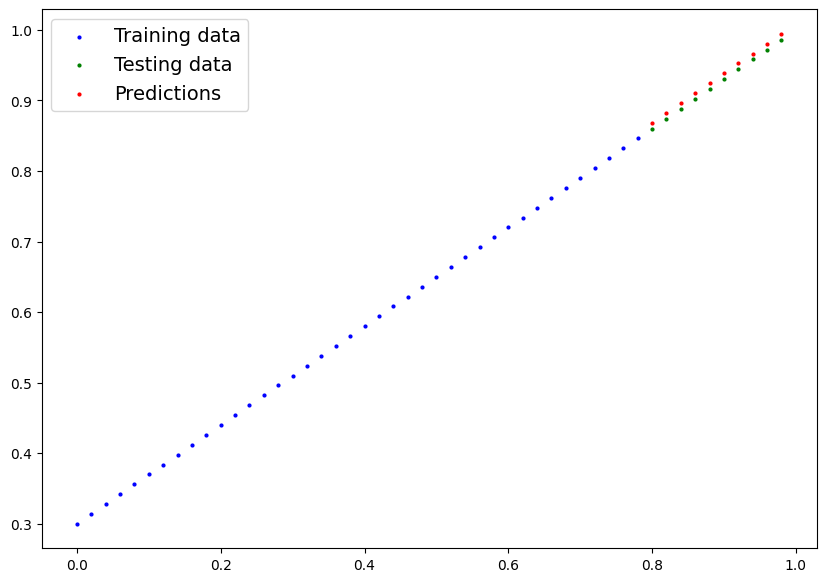

In [263]:
# Make predictions now
with torch.inference_mode():
    y_preds_new = model_0.forward(X_test)

# Plot
plot_predictions(predictions=y_preds_new)

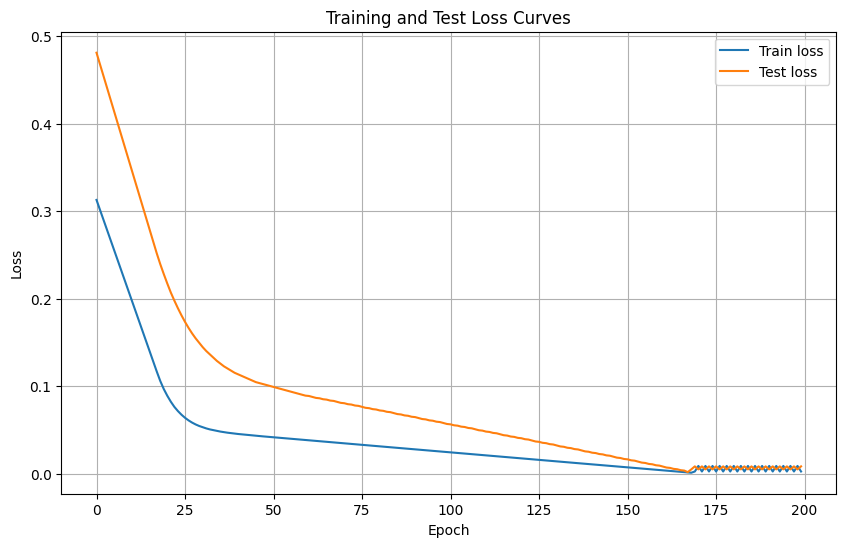

In [264]:
# Loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(metrics["train_loss"])), metrics["train_loss"], label="Train loss")
plt.plot(range(len(metrics["test_loss"])), metrics["test_loss"], label="Test loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid()

## 4. Saving a model in PyTorch

3 main methods:

1. `torch.save()` - allows to save PyTorch model in Python's [pickle](https://docs.python.org/3/library/pickle.html) format
2. `torch.load()` - allows to load the pickled PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary
   1. Can also just save the state_dict using `torch.save()`

In [265]:
from pathlib import Path

# 1. Create models directory
MODEL_SAVE_DIR = Path("models")
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "1_PyTorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_SAVE_DIR / MODEL_NAME

# 3. Save the state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\1_PyTorch_workflow_model_0.pth


In [266]:
!dir -l models

 Volume in drive D is Misc
 Volume Serial Number is 6E3B-3716

 Directory of d:\PyTorch-practice


 Directory of d:\PyTorch-practice\models

04-12-2025  21:33    <DIR>          .
04-12-2025  21:32    <DIR>          ..
04-12-2025  22:06             2,109 1_PyTorch_workflow_model_0.pth
               1 File(s)          2,109 bytes
               2 Dir(s)  94,308,372,480 bytes free


File Not Found


## 5. Loading a PyTorch model

Since we will be loading a `state_dict` instead of an entire model, we have to create a new instance of the model calss and load the saved `state_dict` into that

In [267]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [268]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [269]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [270]:
loaded_model_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting everything together

In [271]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'2.9.1+cu130'

In [272]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

Using device cuda


In [273]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions to ground truth labels.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Plot predictions if they exist
    if predictions is not None:
        # Plot predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

### 6.1 Data

In [274]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start=start, end=end, step=step).unsqueeze(1)
y = weight * X + bias

In [275]:
split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

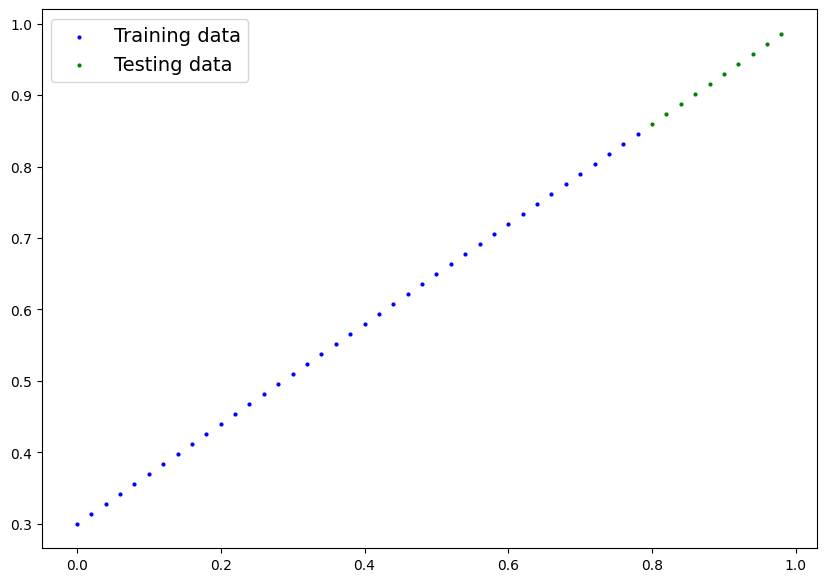

In [276]:
plot_predictions()

### 6.2 PyTorch Linear model

In [277]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # self.weights = nn.Parameter(torch.randn(1, device=device, requires_grad=True, dtype=torch.float))
        # self.bias = nn.Parameter(torch.randn(1, device=device, requires_grad=True, dtype=torch.float))
        # Use nn.Linear() for creating model params (linear transform/probing layer/fully connected layer/dense layer)
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(X)
    
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [278]:
# Check current device for model
print(next(model_1.parameters()).device)
# Set the model to use the target device
model_1.to(device=device)

print(next(model_1.parameters()).device)

cpu
cuda:0


### 6.3 Training

We need
* Loss function
* Optimizer
* Training loop
* Testing loop

In [279]:
Loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [280]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on target device
X_train = X_train.to(device=device)
X_test = X_test.to(device=device)
y_train = y_train.to(device=device)
y_test = y_test.to(device=device)

for epoch in range(epochs):
    model_1.train()

    y_pred = model_1(X_train)

    loss = Loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = Loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411


Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 140 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 150 | Loss: 0.0012645035749301314 | Test loss: 0.0

In [281]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Make predictions and evaluate

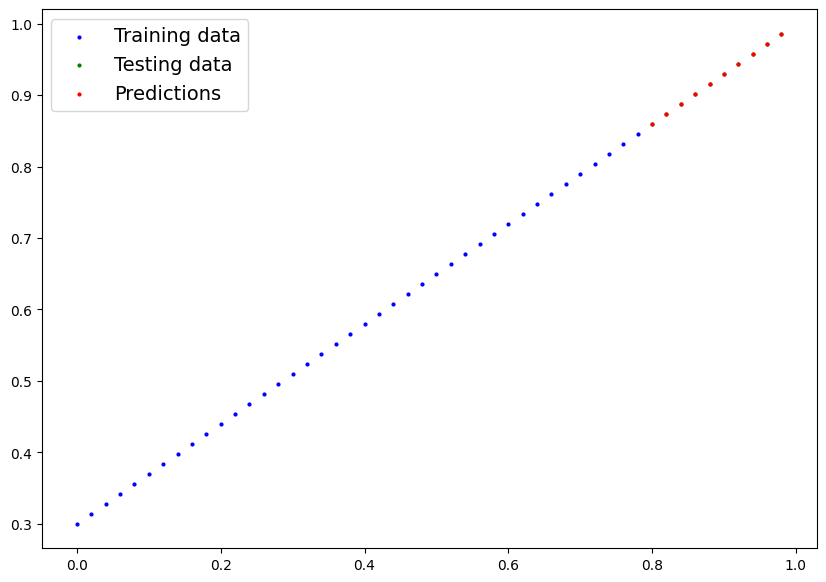

In [288]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading model

In [296]:
from pathlib import Path

MODEL_SAVE_DIR = Path('models')
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_NAME = '1_PyTorch_workflow_model_1.pth'

MODEL_SAVE_PATH = MODEL_SAVE_DIR / MODEL_NAME
print(MODEL_SAVE_PATH)

torch.save(model_1.state_dict(), f=MODEL_SAVE_PATH)

loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.to(device=device)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

models\1_PyTorch_workflow_model_1.pth


<All keys matched successfully>

In [297]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [299]:
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_1(X_test)

loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')